Matplotlib is building the font cache; this may take a moment.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 36)                2340      
                                                                 
Total params: 33,764
Trainable params: 33,764
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50


2025-05-15 03:18:59.844083: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2856/2856 [==============================] - 6s 2ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 2/50
2856/2856 [==============================] - 5s 2ms/step - loss: 0.0037 - root_mean_squared_error: 0.0605 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 3/50
2856/2856 [==============================] - 5s 2ms/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0634
Epoch 4/50
2856/2856 [==============================] - 5s 2ms/step - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 5/50
2856/2856 [==============================] - 5s 2ms/step - loss: 0.0035 - root_mean_squared_error: 0.0596 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630
Epoch 6/50
2856/2856 [==============================] - 5s 2ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0040 - val

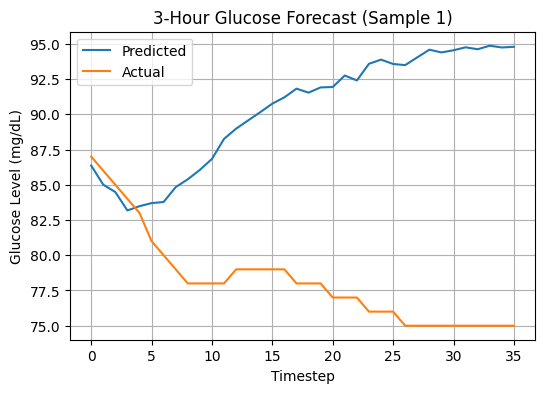

1/1 [==============================] - 0s 12ms/step


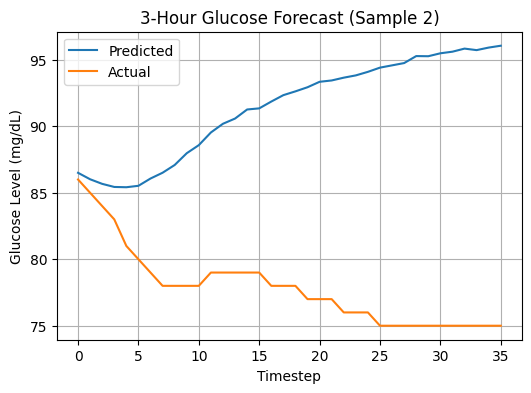

1/1 [==============================] - 0s 8ms/step


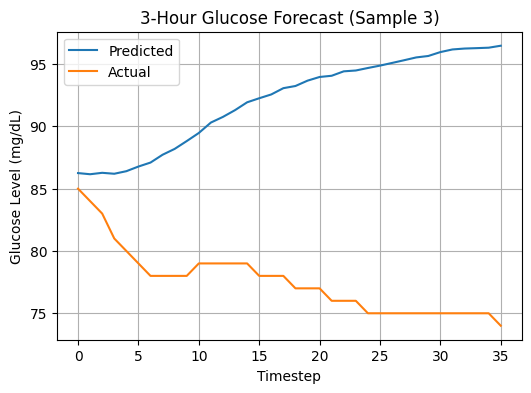

1/1 [==============================] - 0s 9ms/step


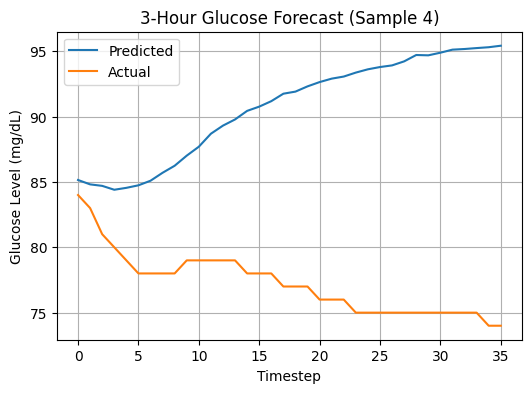

1/1 [==============================] - 0s 8ms/step


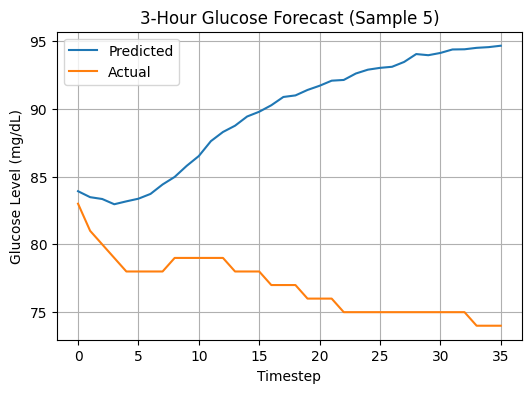

In [2]:

import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
df = pd.read_csv('colas.csv')
df = df[['time', 'gl']]

def str_to_time(s):
    date_part, time_part = s.split(' ')
    y, m, d = map(int, date_part.split('-'))
    h, mi, sec = map(int, time_part.split(':'))
    return datetime.datetime(y, m, d, h, mi, sec)

df['time'] = df['time'].apply(str_to_time)
df.index = df.pop('time')

# Normalize glucose values
scaler = MinMaxScaler()
glucose = pd.Series(scaler.fit_transform(df[['gl']]).flatten(), index=df.index)

# Create sequences for multi-step forecasting (3 hours ahead)
WINDOW_SIZE = 5
FORECAST_HORIZON = 36

def df_to_X_y(df, window_size=5, forecast_horizon=36):
    df_as_numpy = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_numpy) - window_size - forecast_horizon):
        row = [[a] for a in df_as_numpy[i:i+window_size]]
        label = df_as_numpy[i+window_size:i+window_size+forecast_horizon]
        X.append(row)
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_X_y(glucose, WINDOW_SIZE, FORECAST_HORIZON)

# Train/Val/Test split
X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_val, y_val = X[int(len(X)*0.8):int(len(X)*0.9)], y[int(len(y)*0.8):int(len(y)*0.9)]
X_test, y_test = X[int(len(X)*0.9):], y[int(len(y)*0.9):]

# Model definition
model = Sequential()
model.add(InputLayer((WINDOW_SIZE, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(FORECAST_HORIZON))

model.summary()

cp = ModelCheckpoint('model_final/model.keras', save_best_only=True)
es = EarlyStopping(patience=5, restore_best_weights=True)

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp, es])

# Load best model and evaluate
model = tf.keras.models.load_model('model_final/model.keras', custom_objects={'RootMeanSquaredError': RootMeanSquaredError()})

# Predict and plot first 5 test samples
for i in range(5):
    pred = model.predict(X_test[i:i+1])[0]
    actual = y_test[i]
    pred_real = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    actual_real = scaler.inverse_transform(actual.reshape(-1, 1)).flatten()
    
    plt.figure(figsize=(6, 4))
    plt.plot(pred_real, label='Predicted')
    plt.plot(actual_real, label='Actual')
    plt.title(f"3-Hour Glucose Forecast (Sample {i+1})")
    plt.xlabel("Timestep")
    plt.ylabel("Glucose Level (mg/dL)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [3]:
# Save the trained model
model.save("glucose_lstm_model.h5")

# Save the scaler
import joblib
joblib.dump(scaler, "glucose_scaler.gz")


['glucose_scaler.gz']